# import

In [1]:
# import

import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import rcParams
from operator import itemgetter
from typing import Callable, Dict, List, Set, Tuple
from scipy.optimize import curve_fit
import csv
import json
from collections import defaultdict
from scipy.signal import savgol_filter
import math 
import warnings
warnings.simplefilter('ignore', np.RankWarning)

from util import calculate_derivative,pointInterval_to_pressure,point_dt_to_pressure
from baseline import detect_breakpoints_startPoint, detect_breakpoints, detect_breakpoints_2, detect_breakpoints_3,detect_breakpoints_4,detect_breakpoints_startPoint2
from plot import PlotNSave
from data_load_N_preprocess import LoadNPreprocessData
from pattern_recognition5 import polyval_func_wrapper,linear_func_wrapper,PatternRecognition
from advancedMethod_1 import detect_max_FOD

# load data and process

## synthetic

In [2]:
#experiment setup
ground_truth_synthetic=[107, 164, 243, 328, 375, 446, 644, 713, 771, 820, 887, 953, 1036, 1101, 1179, 1254, 1319, 1396, 1456, 1513, 1598, 1648, 1719, 1784, 1875, 1938, 2017, 2073, 2185, 2247, 2315, 2369, 2433, 2487, 2552, 2610, 2835, 2916, 2965, 3044, 3101, 3240, 3284, 3368, 3411]
print("len(ground_truth_synthetic):",len(ground_truth_synthetic))
# colum_names ={"pressure":{"Date","Pressure (psia)","first_order_derivative","second_order_derivative"},
#                     "rate":{"Time@end","Liquid rate (STB/D)"}}

colum_names_synthetic={"pressure":{"time":"Date",
                        "measure":"Pressure (psia)",
                        "first_order_derivative":"first_order_derivative",
                        "second_order_derivative":"second_order_derivative"},
             "rate":{"time":"Time@end",
                     "measure":"Liquid rate (STB/D)"}}
data_inOneRow_synthetic=400
pressure_filePath="../data_input/Synthetic_Data.xlsx"
rate_filePath="../data_input/Synthetic_Data.xlsx"

processed_data=LoadNPreprocessData(pressure_filePath=pressure_filePath, 
                 rate_filePath=rate_filePath, 
                 colum_names=colum_names_synthetic, 
                 use_SG_smoothing=False)
pressure_df_synthetic=processed_data.pressure_df
rate_df_synthetic=processed_data.rate_df

print("len(pressure_df_synthetic)",len(pressure_df_synthetic))
print("len(rate_df_synthetic)",len(rate_df_synthetic))

pressure_measure_synthetic=list(pressure_df_synthetic[colum_names_synthetic["pressure"]["measure"]])
pressure_time_synthetic=list(pressure_df_synthetic[colum_names_synthetic["pressure"]["time"]])

len(ground_truth_synthetic): 45
---load data from 'txt' or 'xlsx' files...
---The first & second order derivative has been calculated and appended to pressure dataframe
len(pressure_df_synthetic) 3519
len(rate_df_synthetic) 95


## denoised data

In [3]:
#experiment setup
ground_truth_temp=[2249,  2467,  2805,[2875, 2876],3100,3561,3994,[4228, 4232],4753,4895, 5297,5436,5985,[6543, 6547], 7249,[7544, 7545],7946,[8362, 8364],9025,[9607, 9608],10149,10216, 10528,[10801, 10804],11340,  11479,12363,[13039, 13040],13868, 14086,14774,15341,16098,16619,[17589, 17590],18435,19643,19764,20021,20349,20701,21030,21974,22186,22710,23220,24215,24685,25717,26006,26656, 26759,27023,[27316,27327],27773,[27966,27970],28322,28497,28832,29115]
colum_names_denoised   ={"pressure":{"time":"Elapsed time",
                             "measure":"Data",
                             "first_order_derivative":"first_order_derivative",
                             "second_order_derivative":"second_order_derivative"},
                "rate":{"time":"Elapsed time",
                        "measure":"Liquid rate"}}
data_inOneRow_denoised=1000
pressure_filePath="../data_input/EAGE_Shchipanov_2017/Pressure.txt"
rate_filePath="../data_input/EAGE_Shchipanov_2017/Rate.txt"
ground_truth=[]
for point in ground_truth_temp: 
    if "list" in str(type(point)):
        ground_truth.append(math.ceil(sum(point)/len(point)))
    else:
        ground_truth.append(point)
                     

processed_data_denoised=LoadNPreprocessData(pressure_filePath=pressure_filePath, 
                 rate_filePath=rate_filePath, 
                 colum_names=colum_names_denoised, 
                 use_SG_smoothing=True)
pressure_df_denoised=processed_data_denoised.pressure_df

# pressure_df_denoised=pressure_df_denoised.iloc[0:3000]

pressure_df=pressure_df_denoised
pressure_measure_denoised=list(pressure_df[colum_names_denoised["pressure"]["measure"]])
print("len(pressure_measure_denoised)",len(pressure_measure_denoised))
pressure_time_denoised=list(pressure_df[colum_names_denoised["pressure"]["time"]])
second_derivatives=list(pressure_df[colum_names_denoised["pressure"]["second_order_derivative"]])
# ground truth adapted for denoise data
ground_truth_denoised=[2248, 2467, 2804, 2884, 3095, 3560, 3987, 4246, 4750, 4899, 5297, 5436, 5983, 6543, 7249, 7545, 7946, 8361, 9024, 9619, 10149, 10224, 10527, 10800, 11340,11490, 12362, 13040, 13867, 14089, 14766, 15348, 16097, 16619, 17589, 18434, 19642, 19777, 20014, 20358, 20700, 21025, 21974, 22183, 22709, 23219, 24215, 24683, 25698, 26011, 26656, 26753, 27022, 27315, 27760, 27969, 28322, 28494, 28831, 29115]
print("len(ground_truth_denoised)",len(ground_truth_denoised))
ground_truth_denoised.remove(9024)
ground_truth_denoised.remove(10800)
ground_truth_denoised.remove(2467)
ground_truth_denoised.remove(10224)
ground_truth_denoised.remove(21025)
ground_truth_denoised.remove(26753)

print("after uncorrect ground truth")
print("len(ground_truth_denoised)",len(ground_truth_denoised))

---load data from 'txt' or 'xlsx' files...
check the time type
---denoising data using S-G smoothing...
---The first & second order derivative has been calculated and appended to pressure dataframe
len(pressure_measure_denoised) 29813
len(ground_truth_denoised) 60
after uncorrect ground truth
len(ground_truth_denoised) 54


# detect

## get indices of max abs first order derivatives

In [4]:
pressure_df=pressure_df_denoised
time_step=4
point_indices_maxFOD=detect_max_FOD(pressure_df=pressure_df,time_step=time_step)
len(point_indices_maxFOD)

1016

## tangent analysis for nearby points

In [5]:
percentile_tuning={
                    "buildUp":{"left":[100,10],
                              "right":[100,10]},
                   "drawDown":{"left":[95,6],
                              "right":[95,3]}
                   }

fine_tuning={"buildUp":{"left_top":1.1,
                    "left_bottom":1.1,
                    "right_top":1.1,
                    "right_bottom":0.9},
            "drawDown":{"left_top":1.1,
                        "left_bottom":-1.1,
                        "right_top":0.9,
                        "right_bottom":1.1}}
# fine_tuning={"buildUp":{"left_top":1,
#                                     "left_bottom":1,
#                                     "right_top":1,
#                                     "right_bottom":1},
#                             "drawDown":{"left_top":1,
#                                         "left_bottom":1,
#                                         "right_top":1,
#                                         "right_bottom":1}}

point_halfWindow=8
identfication_UsePattern=PatternRecognition(point_halfWindow=point_halfWindow,time_halfWindow_forPredict=1,time_halfWindow_forLearn=1,percentile_tuning=percentile_tuning,fine_tuning=fine_tuning)

In [6]:
data_forTangentPlot=identfication_UsePattern.produce_tangent_inPointWindow(pressure_measure=pressure_measure_denoised,
                                    pressure_time=pressure_time_denoised,
                                    points=point_indices_maxFOD,
                                    fitting_type="polynomial",
                                                                   point_halfWindow_tagentAnalyze=5,
                                    time_halfWindow=1)
data_forTangentPlot

-------calculate_Parameters_allCurve using 'polynomial' fitting


,point_index,pressure_time_left,pressure_measure_left,left_curves_parameters,tangent_left,pressure_time_right,pressure_measure_right,right_curves_parameters,tangent_right
0,20,"[-1.795833, -1.333333, -0.983333, -0.55, 0.0]","[-8.185458, -6.079437, -4.013442, -1.987091, 0.0]","[-0.28360893636008, -1.1409249718583305, 3.469...","[4.823497901750213, 4.999492277105107, 4.89072...","[0.0, 0.329167, 0.916667, 1.529167, 2.166667]","[0.0, 1.948213, 3.857932, 5.72954, 7.56342]","[0.07546288884081574, -0.5309650335965718, 4.3...","[4.305873062077131, 3.9808501465611847, 3.5226..."
1,32,"[-2.370833, -1.754167, -1.15, -0.3, 0.0]","[-6.392904, -4.741917, -3.12636, -1.545848, 0.0]","[0.04502136364908392, 0.1899040098980033, 2.77...","[2.634285581665273, 2.5249313640799755, 2.5174...","[0.0, 0.108333, 0.1125, 0.116667, 0.133333]","[0.0, 1.511568, 2.98924, 4.433398, 5.844426]","[54.54076811779012, -45.27165120597792, 35.408...","[35.4088800996166, 27.52033024642114, 27.29360..."
2,33,"[-1.8625, -1.258333, -0.408333, -0.108333, 0.0]","[-6.253485, -4.637928, -3.057417, -1.511568, 0.0]","[0.2201866120259336, 1.3088173619889327, 4.776...","[2.1928007953014492, 2.528800894911515, 3.8179...","[0.0, 0.004167, 0.008333, 0.025, 0.075]","[0.0, 1.477672, 2.92183, 4.332858, 5.711138]","[-46.818104755173664, 96.02122123602007, -9.92...","[-9.923812599216788, -9.126010574558274, -8.33..."
3,345,"[-0.3, -0.283333, -0.266667, -0.2, 0.0]","[-3.254859, -2.406752, -1.612377, -0.826054, 0.0]","[-0.5244648757955981, -4.8847817988934805, 6.3...","[9.148638096259605, 9.001105969182582, 8.85270...","[0.0, 0.016667, 0.166667, 0.216667, 0.233333]","[0.0, 0.909244, 1.814721, 2.660294, 3.478995]","[25.562855916605432, -35.86857375580827, 22.05...","[22.05249150064354, 20.87815169510165, 12.2265..."
4,375,"[-0.208333, -0.191667, -0.175, -0.008333, 0.0]","[-3.859929, -2.889233, -1.960032, -1.013397, 0.0]","[-90.56227460159724, -70.96270166550923, 5.009...","[22.78555026373207, 22.23139453402958, 21.5262...","[0.0, 0.004167, 0.008333, 0.041667, 0.145833]","[0.0, 1.048901, 2.090122, 3.078079, 4.019943]","[22.850114238455625, -36.24043201082578, 29.40...","[29.40970282774282, 29.108865367906418, 28.810..."
...,...,...,...,...,...,...,...,...,...
1008,29768,"[-6.508333, -4.504166, -2.5, -1.133333, 0.0]","[-2.485544, -1.861492, -1.239155, -0.618626, 0.0]","[0.0017889308225655539, 0.037809862755451784, ...","[0.2872049804769751, 0.3203096683407711, 0.396...","[0.0, 0.016667, 2.020834, 4.025, 5.0125]","[0.0, 0.616632, 1.231175, 1.843538, 2.453626]","[0.10705071497719067, -0.7132460922966101, 1.4...","[1.4883233263364362, 1.4646371935933615, -0.08..."
1009,29773,"[-5.0125, -3.008333, -1.004167, -0.016667, 0.0]","[-2.444716, -1.830172, -1.21781, -0.607721, 0.0]","[0.008323146589871258, 0.0871691283848002, 0.7...","[0.47385073632673147, 0.4218677555216629, 0.57...","[0.0, 0.004167, 0.070833, 0.266667, 0.283333]","[0.0, 0.605261, 1.207968, 1.808029, 2.405351]","[-18.73156368086409, 16.98834880334799, 4.3461...","[4.346149810955579, 4.486754951505028, 6.47087..."
1010,29784,"[-2.429167, -2.3125, -1.1125, -1.095833, 0.0]","[-2.322126, -1.736693, -1.154466, -0.575538, 0.0]","[0.24103621303637526, 0.8047773756997582, 1.38...","[1.7443134111202636, 1.5320744823824906, 0.491...","[0.0, 0.004167, 0.0125, 0.016667, 0.020833]","[0.0, 0.572053, 1.140529, 1.705334, 2.266376]","[53.46625412333971, -84.63069282199058, 41.252...","[41.252108637485094, 40.549581589812156, 39.16..."
1011,29801,"[-1.433333, -1.370833, -1.233333, -1.216667, 0.0]","[-2.044044, -1.525759, -1.012261, -0.503643, 0.0]","[-6.157463635981383, -21.30334312514942, -16.3...","[6.810359630995663, 7.384919898024869, 8.14096...","[0.0, 0.283333, 1.116667, 3.120833, 4.15]","[0.0, 0.498577, 0.991993, 1.480157, 1.962974]","[0.001248817594673307, -0.01591424784410752, 0...","[0.5074560509347609, 0.49873874396231943, 0.47..."


<Figure size 1440x720 with 0 Axes>

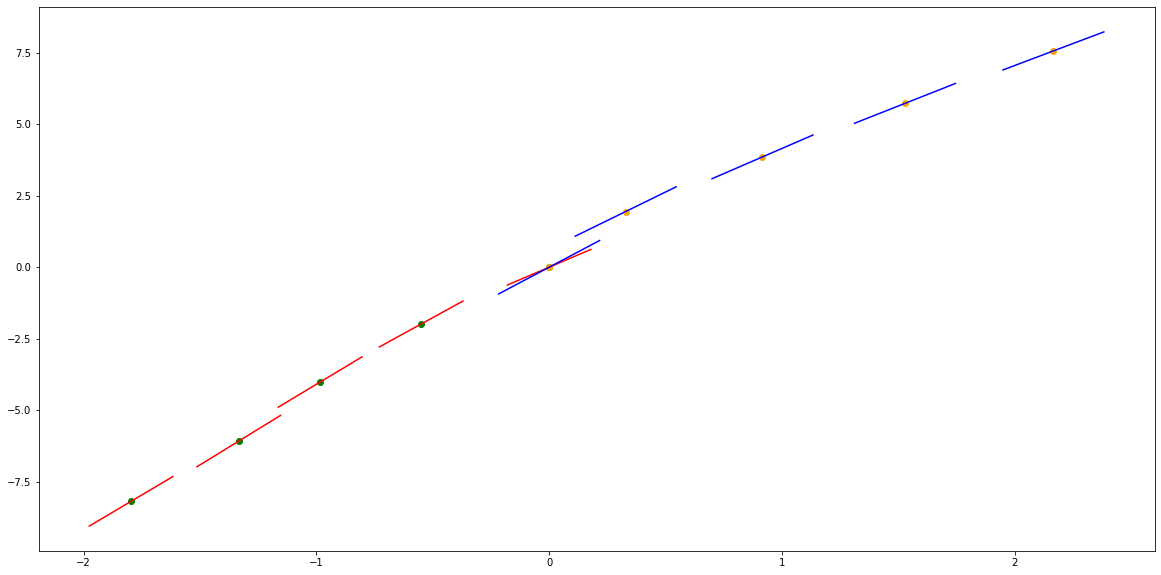

In [7]:
point_index=20 
identfication_UsePattern.plot_tangent_inPointWindow(data_forTangentPlot,point_index)

In [9]:
data_forTangentPlot.iloc[0]["tangent_left"],data_forTangentPlot.iloc[0]["tangent_right"]

(array([34.32838019, 14.19626694,  0.69363812, 11.18805008, 27.15550637]),
 array([1.37772142, 1.66438437, 4.32200518, 4.82349975, 4.99949312]))

In [ ]:
data_plotPoint=data_forPredict.loc[data_forPredict['point_index'] == point_index]

In [10]:
data_inWindow=identfication_UsePattern.extract_points_inTimeWindow(pressure_measure=pressure_measure_denoised,
                                    pressure_time=pressure_time_denoised,
                                    points=point_indices_maxFOD,
                                    time_halfWindow=1)
data_inWindow

,point_index,pressure_time_left,pressure_measure_left,pressure_time_right,pressure_measure_right
0,13,"[-1.15, -1.116667, -1.083333, -1.033333, -0.83...","[-16.783921, -14.25656, -11.773056, -9.333028,...","[0.0, 0.083333, 1.170833, 1.608333, 2.070833, ...","[0.0, 2.228401, 4.415625, 6.562057, 8.668079, ..."
1,15,"[-2.254167, -2.204167, -2.004167, -1.683333, -...","[-16.188682, -13.748653, -11.351716, -8.997488...","[0.0, 0.4375, 0.9, 1.25, 1.683333, 2.233333, 2...","[0.0, 2.146432, 4.252453, 6.318448, 8.344799, ..."
2,17,"[-2.904167, -2.583333, -2.25, -2.070833, -1.98...","[-15.604169, -13.249941, -10.938039, -8.668079...","[0.0, 0.35, 0.783333, 1.333333, 1.6625, 2.25, ...","[0.0, 2.065995, 4.092346, 6.079437, 8.02765, 9..."
3,18,"[-2.933333, -2.6, -2.420833, -2.3375, -1.25, -...","[-15.315936, -13.004033, -10.734073, -8.505673...","[0.0, 0.433333, 0.983333, 1.3125, 1.9, 2.5125,...","[0.0, 2.026351, 4.013442, 5.961655, 7.871374, ..."
4,20,"[-3.404167, -3.320833, -2.233333, -1.795833, -...","[-14.747515, -12.519114, -10.33189, -8.185458,...","[0.0, 0.329167, 0.916667, 1.529167, 2.166667, ...","[0.0, 1.948213, 3.857932, 5.72954, 7.56342, 9...."
...,...,...,...,...,...
3587,29799,"[-0.9, -0.891667, -0.8875, -0.883334, -0.86666...","[-7.590759, -7.022284, -6.457478, -5.896436, -...","[0.0, 0.016666, 1.233333, 1.516666, 2.35, 4.35...","[0.0, 0.508617, 1.012261, 1.510837, 2.004254, ..."
3588,29801,"[-1.916667, -1.5375, -1.454167, -1.433333, -1....","[-3.626696, -3.094606, -2.567024, -2.044044, -...","[0.0, 0.283333, 1.116667, 3.120833, 4.15, 4.71...","[0.0, 0.498577, 0.991993, 1.480157, 1.962974, ..."
3589,29803,"[-2.570834, -2.55, -2.4875, -2.35, -2.333334, ...","[-3.559018, -3.036037, -2.517752, -2.004254, -...","[0.0, 2.004166, 3.033333, 3.6, 4.233333, 5.95,...","[0.0, 0.488163, 0.970981, 1.448359, 1.920205, ..."
3590,29804,"[-4.554166, -4.491666, -4.354166, -4.3375, -3....","[-3.524201, -3.005915, -2.492417, -1.9838, -1....","[0.0, 1.029167, 1.595834, 2.229167, 3.945834, ...","[0.0, 0.482817, 0.960195, 1.432041, 1.898261, ..."


In [11]:
parameters_allCurves=identfication_UsePattern.calculate_Parameters_allCurve(data_inWindow,fitting_type="polynomial")
parameters_allCurves

-------calculate_Parameters_allCurve using 'polynomial' fitting


,point_index,left_curves_parameters,right_curves_parameters
0,13,"[37.48764427273823, 54.635083364410825, 27.155...","[-0.2836100422525628, 1.7554357333411252, 1.37..."
1,15,"[-0.8530429132728141, -5.902123358430818, -2.2...","[-0.0830254490965028, 0.1478450045067414, 4.87..."
2,17,"[0.8223315301096433, 2.4260430236388357, 5.630...","[0.026507398584767392, -0.5466814296766748, 5...."
3,18,"[1.2682101999003697, 4.89908143294158, 8.82643...","[0.08446011608807416, -0.7033639898874184, 5.1..."
4,20,"[-0.28360893636008, -1.1409249718583305, 3.469...","[0.07546288884081574, -0.5309650335965718, 4.3..."
...,...,...,...
3587,29799,"[48.572424971097156, 54.98719304742256, 18.126...","[0.021812334904401834, -0.22359104047368322, 1..."
3588,29801,"[-6.157463635981383, -21.30334312514942, -16.3...","[0.001248817594673307, -0.01591424784410752, 0..."
3589,29803,"[1.3406265515066202, 4.4476453048033555, 3.859...","[-0.003777728738261781, 0.040530255427440924, ..."
3590,29804,"[0.06292646967775503, 0.27898390114651295, 0.6...","[0.003981783815679646, -0.08308962104907706, 0..."


<Figure size 1440x720 with 0 Axes>

In [12]:
tangent_df=identfication_UsePattern.get_tangent(parameters_allCurves=parameters_allCurves,
                    fitting_type="polynomial")
tangent_df

,point_index,left_tangent,right_tangent
0,13,27.155506,1.377721
1,15,-2.259770,4.875550
2,17,5.630811,5.461528
3,18,8.826436,5.140554
4,20,3.469607,4.305873
...,...,...,...
3587,29799,18.126371,1.094140
3588,29801,-16.308727,0.507456
3589,29803,3.859086,0.303647
3590,29804,0.633869,0.766652
